In [1]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
def printattr(name, object):
    print(name)
h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_173_gev_with_spanet_KLFitter.h5', "r")
h5py_file.visititems(printattr)

jet_features
jet_features/barcode
jet_features/btag
jet_features/eta
jet_features/event
jet_features/mass
jet_features/num_of_jets
jet_features/phi
jet_features/pt
klfitter
klfitter/left_target
klfitter/left_target/b
klfitter/right_target
klfitter/right_target/b
klfitter/right_target/q1
klfitter/right_target/q2
klfitter/score
klfitter/score/event_probability
klfitter/score/loglikelihood
lepton_features
lepton_features/charge
lepton_features/eta
lepton_features/mass
lepton_features/phi
lepton_features/pid
lepton_features/pt
met_features
met_features/MET
met_features/eta
met_features/phi
met_features/sumet
neutrino_eta
neutrino_eta/spanet
neutrino_eta/target
parton_features
parton_features/eta
parton_features/masks
parton_features/mass
parton_features/parton_barcode
parton_features/pdgid
parton_features/phi
parton_features/pt
spanet
spanet/left_target
spanet/left_target/b
spanet/left_target/detection
spanet/left_target/mask
spanet/right_target
spanet/right_target/b
spanet/right_target/de

In [3]:
# Caululate delR
lepton_eta = h5py_file['lepton_features/eta'][:]
lepton_phi = h5py_file['lepton_features/phi'][:]
jet_eta = h5py_file['jet_features/eta'][:]
jet_phi = h5py_file['jet_features/phi'][:]
num_of_jets = h5py_file['jet_features/num_of_jets'][:]
num_of_events = len(jet_eta)
print('num_of_events = {}'.format(num_of_events))
del_eta = np.array([jet_eta[i, :num_of_jets[i]] - lepton_eta[i] for i in range(num_of_events)], dtype=object)
del_phi = np.array([[min(abs(jet_phi[i, j]-lepton_phi[i]), 2*np.pi-abs(jet_phi[i, j]-lepton_phi[i])) for j in range(num_of_jets[i])] for i in range(num_of_events)], dtype=object)
delR = np.array([np.sqrt(np.array(del_eta[i])**2 + np.array(del_phi[i])**2) for i in range(num_of_events)])

num_of_events = 266573


/tmp/ipykernel_23884/3874941412.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  delR = np.array([np.sqrt(np.array(del_eta[i])**2 + np.array(del_phi[i])**2) for i in range(num_of_events)])


In [4]:
# pid 11 is electron, 13 is muon.
cut_lepton_pt = np.logical_or(
                np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
cut_delR = np.logical_or(np.logical_and(h5py_file['lepton_features/pid'][:] == 13, [np.all(delR[i] > 0.4) for i in range(num_of_events)]),
        np.logical_and(h5py_file['lepton_features/pid'][:] == 11, [np.all(delR[i] > 0.3) for i in range(num_of_events)]))
cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
cuts_CMS = np.logical_and.reduce((cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))

In [5]:
cut_tmp = [True]*num_of_events
cut_label = ['lepton pt', 'lepton eta', 'delR', 'jet pt', 'jet eta', 'btag']
for i, cut in enumerate([cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag]):
    cut_tmp = np.logical_and(cut_tmp, cut)
    print('After {} cut'.format(cut_label[i]), np.count_nonzero(cut_tmp))

After lepton pt cut 256442
After lepton eta cut 255492
After delR cut 255492
After jet pt cut 214380
After jet eta cut 203240
After btag cut 151851


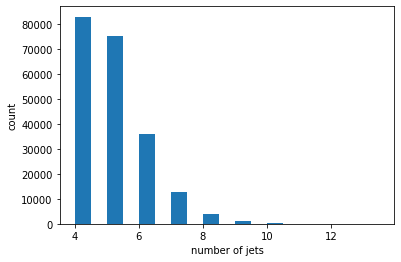

In [6]:
plt.hist(h5py_file['jet_features/num_of_jets'][:][np.logical_and(cut_jet_pt, cut_jet_eta)], bins=np.arange(4, 14, 0.5))
# plt.hist(h5py_file['jet_features/num_of_jets'][:][cuts_CMS], bins=np.arange(4, 14, 0.5))
plt.xlabel('number of jets')
plt.ylabel('count')
plt.show()

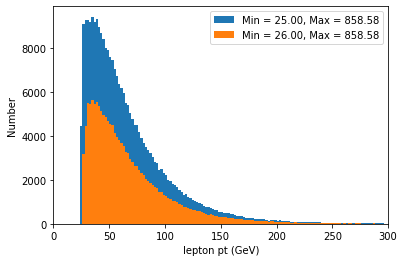

In [11]:
lepton_pt_bins = np.arange(0, 301, 2)
plt.hist(h5py_file['lepton_features/pt'][:], bins=lepton_pt_bins, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['lepton_features/pt'][:]), max(h5py_file['lepton_features/pt'][:])))
plt.hist(h5py_file['lepton_features/pt'][:][cuts_CMS], bins=lepton_pt_bins, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['lepton_features/pt'][:][cuts_CMS]), max(h5py_file['lepton_features/pt'][:][cuts_CMS])))
plt.xlabel('lepton pt (GeV)')
plt.ylabel('Number')
plt.xlim(0, 300)
plt.legend(loc = 'upper right')
plt.show()

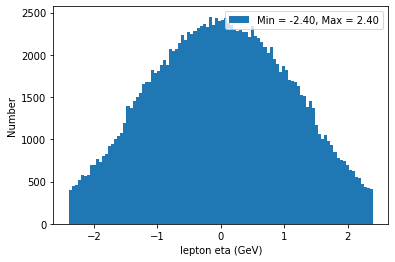

In [12]:
# plt.hist(h5py_file['lepton_features/eta'][:], bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['lepton_features/eta'][:]), max(h5py_file['lepton_features/eta'][:])))
plt.hist(h5py_file['lepton_features/eta'][:][cuts_CMS], bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['lepton_features/eta'][:][cuts_CMS]), max(h5py_file['lepton_features/eta'][:][cuts_CMS])))
plt.xlabel('lepton eta (GeV)')
plt.ylabel('Number')
plt.legend(loc = 'upper right')
plt.show()

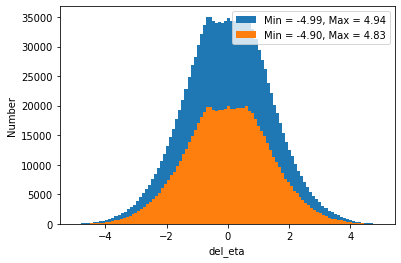

In [14]:
del_eta_flatten = [ele for arr in del_eta for ele in arr]
del_eta_cut_flatten = [ele for arr in del_eta[cuts_CMS] for ele in arr]
plt.hist(del_eta_flatten, bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(del_eta_flatten), max(del_eta_flatten)))
plt.hist(del_eta_cut_flatten, bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(del_eta_cut_flatten), max(del_eta_cut_flatten)))
plt.xlabel('del_eta')
plt.ylabel('Number')
plt.legend(loc = 'upper right')
plt.show()

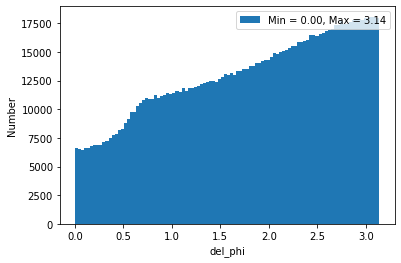

In [16]:
del_phi_flatten = [ele for arr in del_phi for ele in arr]
del_phi_cut_flatten = [ele for arr in del_phi[cuts_CMS] for ele in arr]
plt.hist(del_phi_flatten, bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(del_phi_flatten), max(del_phi_flatten)))
# plt.hist(del_phi_cut_flatten, bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(del_phi_cut_flatten), max(del_phi_cut_flatten)))
plt.xlabel('del_phi')
plt.ylabel('Number')
plt.legend(loc = 'upper right')
plt.show()

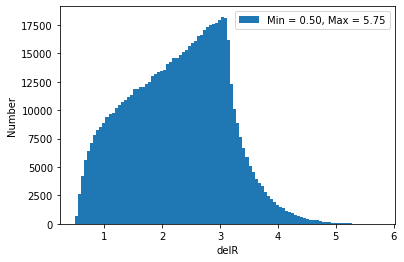

In [21]:
delR_flatten = [ele for arr in delR for ele in arr]
delR_cut_flatten = [ele for arr in delR[cuts_CMS] for ele in arr]
# plt.hist(delR_flatten, bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(delR_flatten), max(delR_flatten)))
plt.hist(delR_cut_flatten, bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(delR_cut_flatten), max(delR_cut_flatten)))
plt.xlabel('delR')
plt.ylabel('Number')
plt.legend(loc = 'upper right')
plt.show()

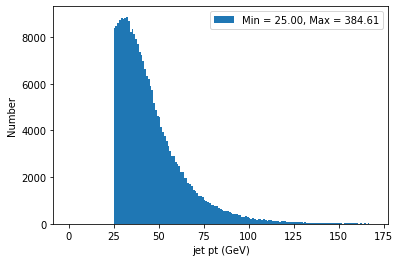

In [25]:
jet_pt_bins = np.arange(0, 170, 1)
plt.hist(h5py_file['jet_features/pt'][:, 3], bins=jet_pt_bins, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['jet_features/pt'][:, 3]), max(h5py_file['jet_features/pt'][:, 3])))
# plt.hist(h5py_file['jet_features/pt'][:, 3][cuts_CMS], bins=jet_pt_bins, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['jet_features/pt'][:, 3][cuts_CMS]), max(h5py_file['jet_features/pt'][:, 3][cuts_CMS])))
plt.xlabel('jet pt (GeV)')
plt.ylabel('Number')
plt.legend(loc = 'upper right')
plt.show()

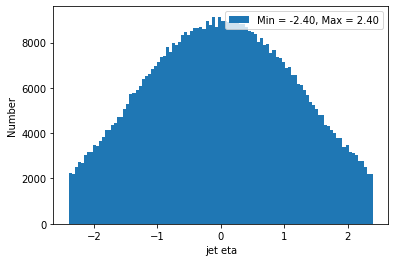

In [29]:
# plt.hist(h5py_file['jet_features/eta'][:, :4].flatten(), bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['jet_features/eta'][:, :4].flatten()), max(h5py_file['jet_features/eta'][:, :4].flatten())))
plt.hist(h5py_file['jet_features/eta'][:, :4][cuts_CMS].flatten(), bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['jet_features/eta'][:, :4][cuts_CMS].flatten()), max(h5py_file['jet_features/eta'][:, :4][cuts_CMS].flatten())))
plt.xlabel('jet eta')
plt.ylabel('Number')
plt.legend(loc = 'upper right')
plt.show()

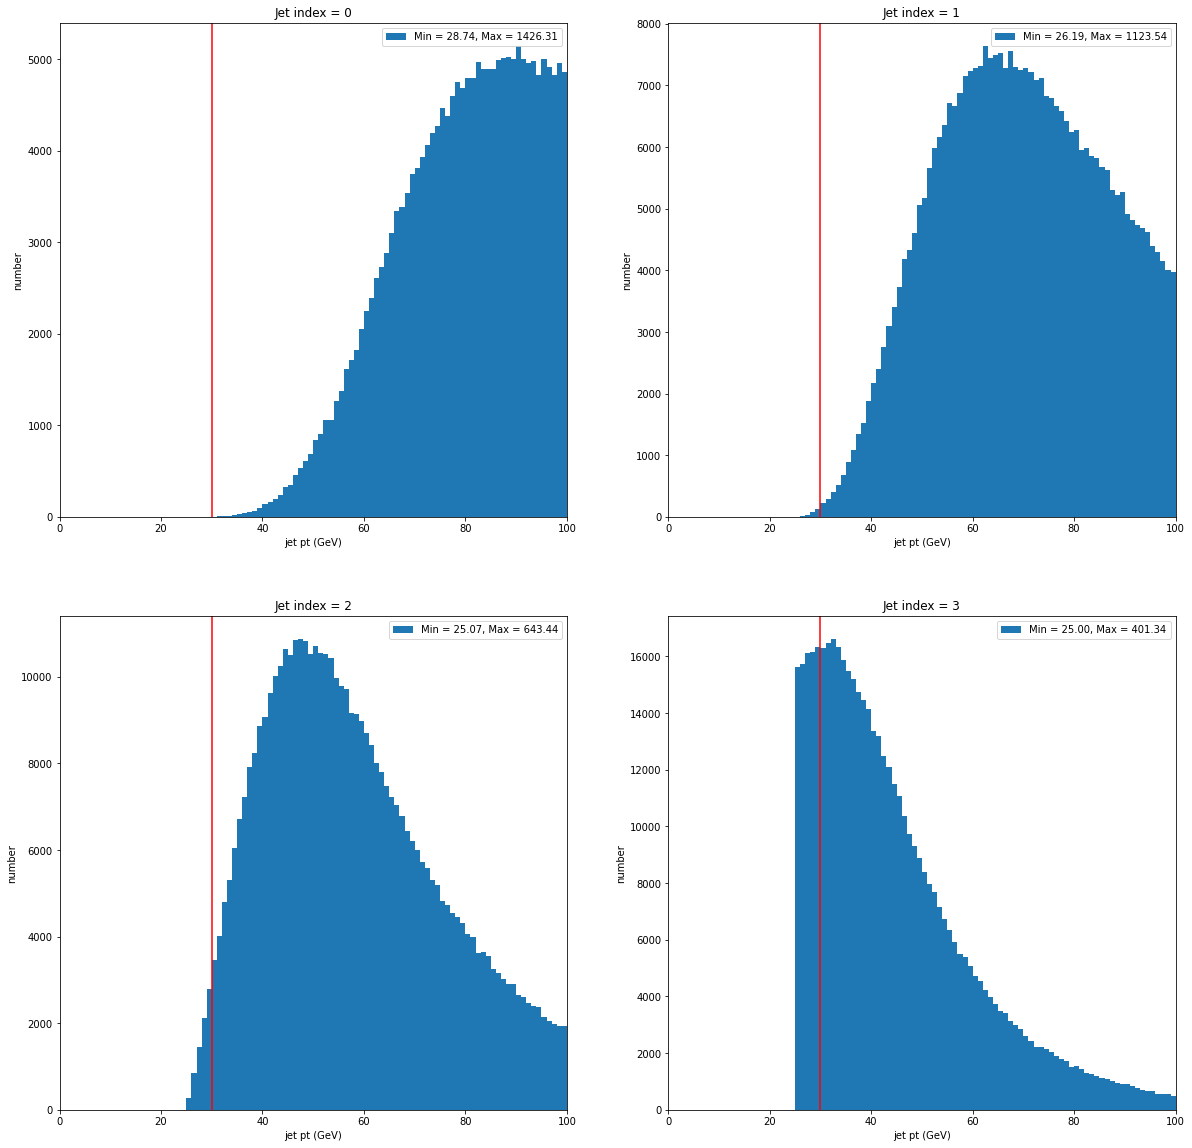

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(h5py_file['jet_features/pt'][:,i], bins=np.arange(0,101,1), label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['jet_features/pt'][:,i]), max(h5py_file['jet_features/pt'][:,i])))
    # plt.hist(h5py_file['jet_features/pt'][:,i][cuts], bins=100, label = 'Min = {:.2f}, Max = {:.2f}'.format(min(h5py_file['jet_features/pt'][:,i][cuts]), max(h5py_file['jet_features/pt'][:,i][cuts])))
    plt.axvline(30, c='r')
    plt.xlim(0, 100)
    plt.title('Jet index = {}'.format(i))
    plt.xlabel('jet pt (GeV)')
    plt.ylabel('number')
    plt.legend()
plt.show()

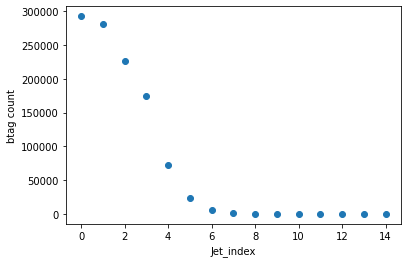

In [ ]:
plt.scatter(range(15), np.sum(h5py_file['jet_features/btag'][:], axis=0))
plt.xlabel('Jet_index')
plt.ylabel('btag count')
plt.show()